## IN3050/IN4050 Mandatory Assignment 2, 2023: Supervised Learning

### Rules

Before you begin the exercise, review the rules at this website:

- https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html 

in particular the paragraph on cooperation. This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers with others. Read also the "Routines for handling suspicion of cheating and attempted cheating at the University of Oslo": 
- https://www.uio.no/english/studies/examinations/cheating/index.html 

By submitting this assignment, you confirm that you are familiar with the rules and the consequences of breaking them.

### Delivery

**Deadline**: Friday, March 24, 2023, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

### What to deliver?

You are recommended to solve the exercise in a Jupyter notebook, but you might solve it in a Python program if you prefer.

#### Alternative 1
If you choose Jupyter, you should deliver the notebook. You should answer all questions and explain what you are doing in Markdown. Still, the code should be properly commented. The notebook should contain results of your runs. In addition, you should make a pdf of your solution which shows the results of the runs. (If you can't export: notebook -> latex -> pdf on your own machine, you may do this on the IFI linux machines.)

#### Alternative 2
If you prefer not to use notebooks, you should deliver the code, your run results, and a pdf-report where you answer all the questions and explain your work.

Here is a list of *absolutely necessary* (but not sufficient) conditions to get the assignment marked as passed:

- You must deliver your code (python file or notebook) you used to solve the assignment.
- The code used for making the output and plots must be included in the assignment. 
- You must include example runs that clearly shows how to run all implemented functions and methods.
- All the code (in notebook cells or python main-blocks) must run. If you have unfinished code that crashes, please comment it out and document what you think causes it to crash. 
- You must also deliver a pdf of the code, outputs, comments and plots as explained above.

Your report/notebook should contain your name and username.

Deliver one single zipped folder (.zip, .tgz or .tar.gz) which contains your complete solution.

Important: if you weren’t able to finish the assignment, use the PDF report/Markdown to elaborate on what you’ve tried and what problems you encountered. Students who have made an effort and attempted all parts of the assignment will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.

### Goals of the assignment
The goal of this assignment is to get a better understanding of supervised learning with gradient descent. It will, in particular, consider the similarities and differences between linear classifiers and multi-layer feed forward networks (multi-layer perceptron, MLP) and the differences and similarities between binary and multi-class classification. A main part will be dedicated to implementing and understanding the backpropagation algorithm. 

### Tools
The aim of the exercises is to give you a look inside the learning algorithms. You may freely use code from the weekly exercises and the published solutions. You should not use ML libraries like scikit-learn or tensorflow.

You may use tools like NumPy and Pandas, which are not specific ML-tools.

The given precode uses NumPy. You are recommended to use NumPy since it results in more compact code, but feel free to use pure python if you prefer. 

### Beware
There might occur typos or ambiguities. This is a revised assignment compared to earlier years, and there might be new typos. If anything is unclear, do not hesitate to ask. Also, if you think some assumptions are missing, make your own and explain them!

### Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn #for datasets
from matplotlib.colors import LinearSegmentedColormap

## Datasets

We start by making a synthetic dataset of 2000 datapoints and five classes, with 400 individuals in each class. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html regarding how the data are generated.) We choose to use a synthetic dataset---and not a set of natural occuring data---because we are mostly interested in properties of the various learning algorithms, in particular the differences between linear classifiers and multi-layer neural networks together with the difference between binary and multi-class data.

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by scikit, but that will not be the case with real-world data.) We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *must not be used* till the end of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments. This is done by the `random_state` argument and the `rng = np.random.RandomState(2022)`.

In [2]:
from sklearn.datasets import make_blobs
X, t_multi = make_blobs(n_samples=[400,400,400, 400, 400], 
                        centers=[[0,1],[4,2],[8,1],[2,0],[6,0]], 
                        cluster_std=[1.0, 2.0, 1.0, 0.5, 0.5],
                        n_features=2, random_state=2022)

In [4]:
indices = np.arange(X.shape[0])
rng = np.random.RandomState(2022)
rng.shuffle(indices)
indices[:10]

array([1018, 1295,  643, 1842, 1669,   86,  164, 1653, 1174,  747])

In [5]:
X_train = X[indices[:1000],:]
X_val = X[indices[1000:1500],:]
X_test = X[indices[1500:],:]
t_multi_train = t_multi[indices[:1000]]
t_multi_val = t_multi[indices[1000:1500]]
t_multi_test = t_multi[indices[1500:]]

Next, we will  make a second dataset by merging classes in (X,t) into two classes and call the new set (X, t2). This will be a binary set.
We now have two datasets:

- Binary set: `(X, t2)`
- Multi-class set: `(X, t_multi)`

In [6]:
t2_train = t_multi_train >= 3
t2_train = t2_train.astype('int')
t2_val = (t_multi_val >= 3).astype('int')
t2_test = (t_multi_test >= 3).astype('int')

We can plot the two traning sets.

Text(0.5, 1.0, 'Multi-class set')

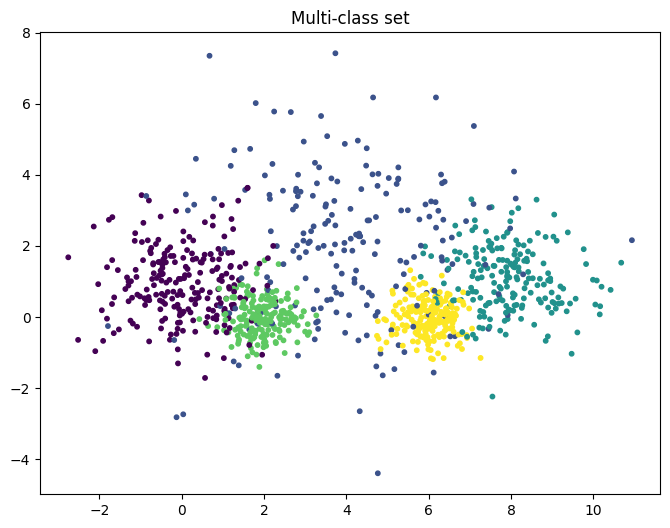

In [6]:
plt.figure(figsize=(8,6)) # You may adjust the size
plt.scatter(X_train[:, 0], X_train[:, 1], c=t_multi_train, s=10.0)
plt.title('Multi-class set')

Text(0.5, 1.0, 'Binary set')

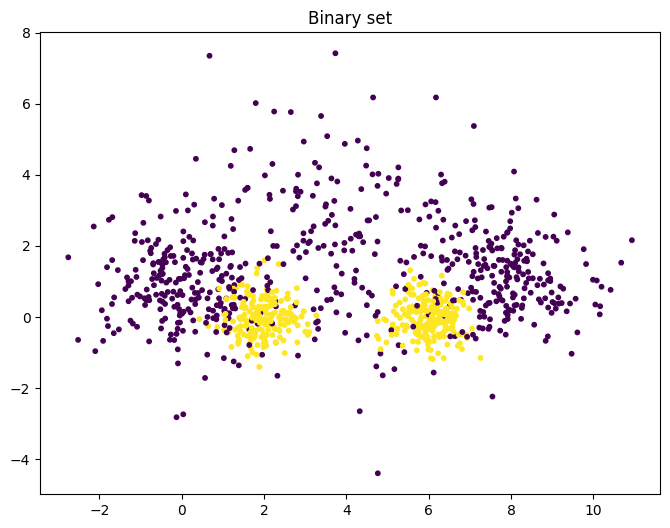

In [51]:
plt.figure(figsize=(8,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=t2_train, s=10.0)
plt.title('Binary set')

# Part I: Linear classifiers
## Linear regression

We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression. You may make your own implementation from scratch or start with the solution to the weekly exercise set 7. 
We include it here with a little added flexibility.

In [7]:
def add_bias(X, bias):
    """X is a Nxm matrix: N datapoints, m features
    bias is a bias term, -1 or 1. Use 0 for no bias
    Return a Nx(m+1) matrix with added bias in position zero
    """
    N = X.shape[0]
    biases = np.ones((N, 1))*bias # Make a N*1 matrix of bias-s
    # Concatenate the column of biases in front of the columns of X.
    return np.concatenate((biases, X), axis  = 1) 

In [8]:
class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""

In [9]:
def accuracy(predicted, gold):
    return np.mean(predicted == gold)

In [10]:
class NumpyLinRegClass():

    def __init__(self, bias=-1):
        self.bias=bias
    
    def fit(self, X_train, t_train, eta = 0.001, epochs=1000, threshold=0.5):
        """X_train is a Nxm matrix, N data points, m features
        t_train is avector of length N,
        the targets values for the training data"""
        
        if self.bias:
            X_train = add_bias(X_train, self.bias)
            
        (N, m) = X_train.shape
        
        self.weights = weights = np.zeros(m)
        
        mse = list()
        acc = list()
        for e in list(range(epochs)):
            y_pred = X_train @ weights
            weights -= eta / N *  X_train.T @ (y_pred - t_train)
            mse.append(np.mean(y_pred - t_train)**2)
            acc.append(accuracy((y_pred > threshold).astype(int),t_train))
        return acc, mse
    
    def predict(self, X, threshold=0.5):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        if self.bias:
            X = add_bias(X, self.bias)
        ys = X @ self.weights
        return ys > threshold

We can train and test a first classifier.

In [11]:
cl = NumpyLinRegClass()
acc, mse = cl.fit(X_train, t2_train, 0.05, epochs=10)

The following is a small procedure which plots the data set together with the decision boundaries. 
You may modify the colors and the rest of the graphics as you like.
The procedure will also work for multi-class classifiers

In [12]:
def plot_decision_regions(X, t, clf=[], size=(8,6)):
    """Plot the data set (X,t) together with the decision boundary of the classifier clf"""
    # The region of the plane to consider determined by X
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Make a make of the whole region
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Classify each meshpoint.
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=size) # You may adjust this

    # Put the result into a color plot
    plt.contourf(xx, yy, Z, alpha=0.2, cmap = 'Paired')

    plt.scatter(X[:,0], X[:,1], c=t, s=10.0, cmap='Paired')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision regions")
    plt.xlabel("x0")
    plt.ylabel("x1")

#    plt.show()

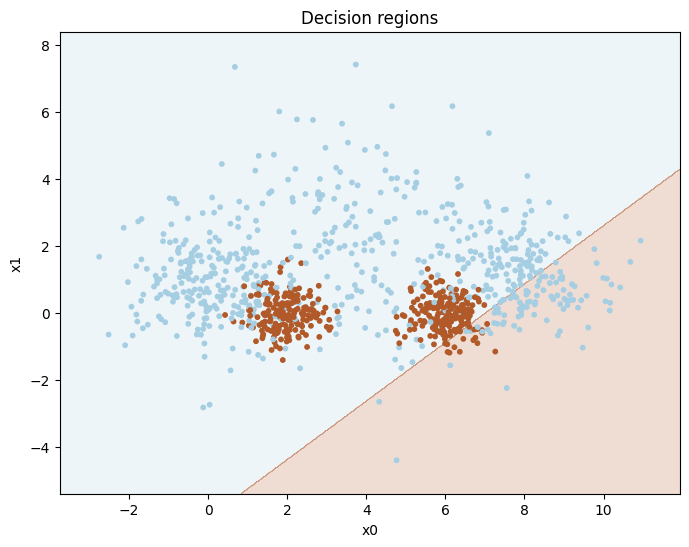

In [13]:
plot_decision_regions(X_train, t2_train, cl)

### Task: Tuning

The result is far from impressive. 
Remember that a classifier which always chooses the majority class will have an accuracy of 0.6 on this data set.

Your task is to try various settings for the two training hyper-parameters, *eta* and *epochs*, to get the best accuracy on the validation set. 

Report how the accuracy vary with the hyper-parameter settings. It it not sufficient to give the final hyperparemters. You must also show how you found them  and results for alternative values you tried aout.

When you are satisfied with the result, you may plot the decision boundaries, as above.

In [14]:
def tuning(cl,min_eta,max_eta,min_epoch,max_epoch):
    etas = np.random.uniform(low=min_eta,high=max_eta,size=10)
    epochs = np.linspace(start=min_epoch,stop=max_epoch,dtype=int)
    A = np.zeros(shape = (len(etas),len(epochs)))
    for j in range(0,len(etas)):
        for i in range(0,len(epochs)-1):
            acc, mse = cl.fit(X_train,t2_train,eta=etas[j],epochs=epochs[i])
            A[j][i] = mse[-1]
    return round(etas[np.argwhere(A == np.amin(A))[0][0]],5), epochs[np.argwhere(A == np.amin(A))[0][1]]

best_etas, best_epochs = tuning(cl,min_eta=0.001,max_eta=0.05, min_epoch=100, max_epoch=10000)

In [15]:
class NumpyLinRegClass2():

    def __init__(self, bias=-1):
        self.bias=bias

    def accuracy(self,y_pred,t):
        return np.sum(y_pred == t)/len(y_pred)
    
    def fit(self, X_train, t_train, eta = 0.01, epochs=100, X_val=[], t_val=[], threshold=0.5):
        """X_train is a Nxm matrix, N data points, m features
        t_train is avector of length N,
        the targets values for the training data"""
        
        if self.bias:
            X_train = add_bias(X_train,self.bias)
            
        (N, m) = X_train.shape
        
        self.weights = weights = np.zeros(m)
        
        mse = list()
        acc = list()
        mse_val = list()
        acc_val = list()
        for e in list(range(epochs)):
            y_pred = X_train @ weights
            weights -= eta / N *  X_train.T @ (y_pred - t_train)
            mse.append(np.mean(y_pred - t_train)**2)
            acc.append(accuracy((y_pred > threshold).astype(int),t_train))
            if len(X_val) > 0:
                mse_val.append(np.mean(add_bias(X_val,self.bias) @ weights - t_val)**2)
                acc_val.append(self.accuracy((add_bias(X_val,self.bias) @ weights > threshold).astype(int),t_val))
        return acc, mse, acc_val, mse_val
    
    def predict(self, X, threshold=0.5):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        if self.bias:
            X = add_bias(X,self.bias)
        ys = X @ self.weights
        return ys > threshold

The accuracy was 72.4%


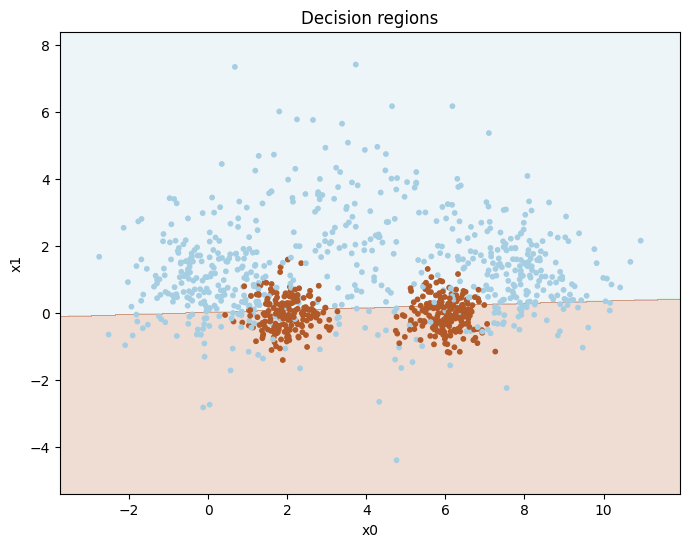

In [16]:
cl2 = NumpyLinRegClass2()
acc, mse, acc_val, mse_val = cl2.fit(X_train=X_train, t_train=t2_train, eta=best_etas, epochs=best_epochs)
print(f"The accuracy was {accuracy(cl2.predict(X_test),t2_test)*100:.1f}%")
plot_decision_regions(X_train, t2_train, cl2)

### Task: Loss
The linear regression classifier is trained with mean squared error loss. So far, we have not calculated the loss explicitly in the code. Extend the code to calculate the loss on the training set for each epoch and to store the losses such that the losses can be inspected after training. 

Also extend the classifier to calculate the accuracy on the training data after each epoch.

Train a classifier with your best settings from last point. After training, plot the loss as a function of the number of epochs. Then plot the accuracy as a function of the number of epochs.

Comment on what you see: Are the function monotone? Is this as expected?

In [17]:
def mse_acc_training(Accuracy, MSE):
    plt.figure()
    plt.plot(list(range(len(Accuracy))), Accuracy)
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy across epochs in data training")
    plt.figure()
    plt.plot(list(range(len(MSE))), MSE)
    plt.xlabel("Number of epochs")
    plt.ylabel("MSE")
    plt.title("MSE across epochs in data training")

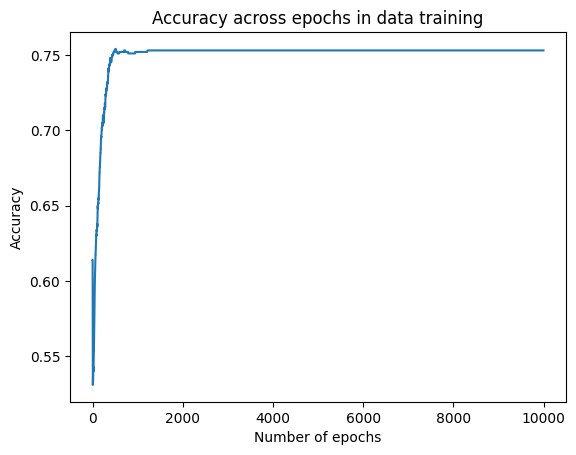

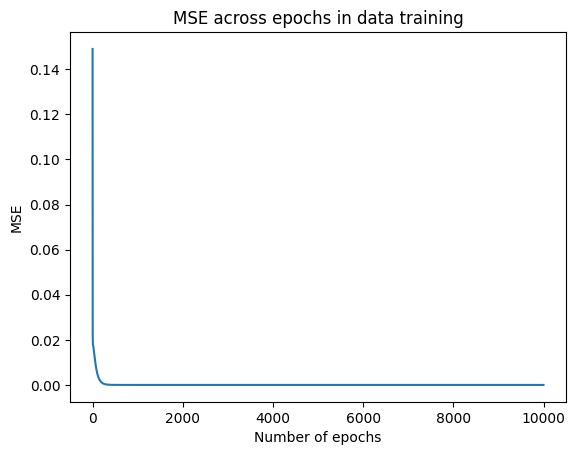

In [18]:
mse_acc_training(acc,mse)

In [19]:
# The results show that MSE dropped rapidly and similarly for MSE, increasing rapidly. This makes a lot of sense, since we are decreasing 
# the error of our model, we also expect the accuracy to increase proportionally. We can also observe that after the first 200 epochs, 
# there is virtually no improvements in the model, and the latter 800 epochs makes no difference. We can use this information to shorten
# the amount of epochs we are running if we are certain that we have the optimal learning rate. 

### Task: Scaling

we have seen in the lectures that scaling the data may improve training speed. 

- Implement a scaler, either standard scaler (normalizer) or max-min scaler 
- Scale the data
- Train the model on the scaled data
- Experiment with hyper-parameter settings and see whether you can speed  up  the training.
- Report final hyper-meter settings and show how you found them.
- Plot the loss curve and the accuracy curve for the classifier trained on scaled data with the best settings you found.

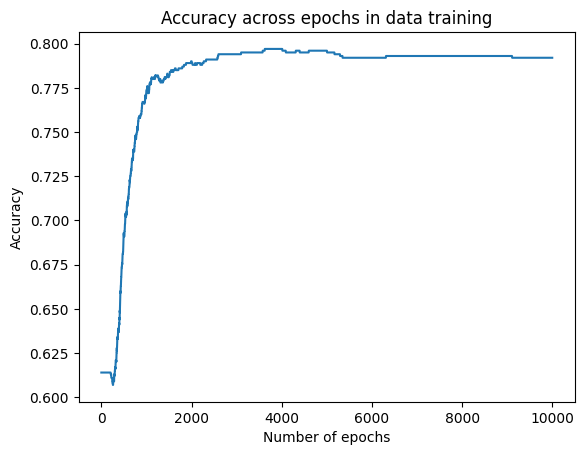

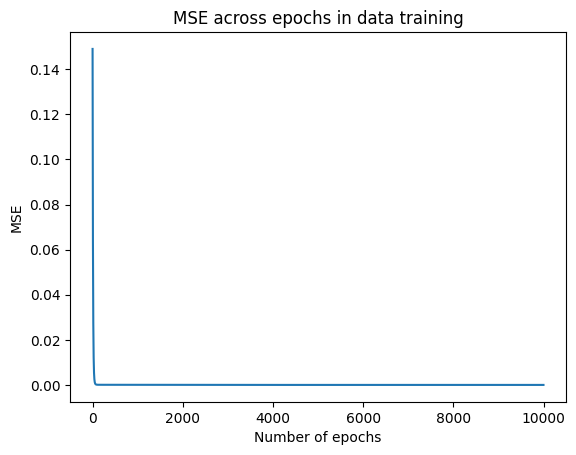

In [19]:
from math import e
#Normalize the data
def normalizer3000(X): return 1/(1+e**-X)
X_train2 = normalizer3000(X_train)

#Train the model on the scaled data and output the accuracy
acc, mse = cl.fit(X_train2, t2_train, eta=best_etas, epochs=best_epochs)

# Plot the loss curve and accuracy curve with scaled data and optimal hyperparameters
mse_acc_training(acc,mse)

## Logistic regression
a) You should now implement a logistic regression classifier similarly to the classifier based on linear regression.
You may use code from the solution to weekly exercise set week07.

b) In addition to the method `predict` which predicts a class for the data, include a method `predict_probability` which predicts the probability of the data belonging to the positive class.

c) As with the classifier based on linear regression, we want to calculate loss and accuracy after each epoch.
The prefered loss for logistic regression is binary cross-entropy. You could have used mean squared error. The most important is that your implementation of the loss corresponds to your implementation of the gradient descent.

d) In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss and the accuracy for the validation set after each epoch. 

e) The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit-method with two keyword arguments, `tol` and `n_epochs_no_update` and stop training when the loss has not improved with more than `tol` after running `n_epochs_no_update` epochs. A possible default value for `n_epochs_no_update` is 5. Also, add an attribute to the classifier which tells us after fitting how many epochs were ran.

f) Train classifiers with various learning rates, and with varying values for `tol` for finding optimal values. Also consider the effect of scaling the data.

g) After a succesful training, plot both training loss and validation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.

In [20]:
from sklearn.datasets import make_blobs
import numpy as np
X, t_multi = make_blobs(n_samples=[400,400,400, 400, 400], 
                        centers=[[0,1],[4,2],[8,1],[2,0],[6,0]], 
                        cluster_std=[1.0, 2.0, 1.0, 0.5, 0.5],
                        n_features=2, random_state=2022)
indices = np.arange(X.shape[0])
rng = np.random.RandomState(2022)
rng.shuffle(indices)
X_train = X[indices[:1000],:]
X_val = X[indices[1000:1500],:]
X_test = X[indices[1500:],:]
t_multi_train = t_multi[indices[:1000]]
t_multi_val = t_multi[indices[1000:1500]]
t_multi_test = t_multi[indices[1500:]]
t2_train = t_multi_train >= 3
t2_train = t2_train.astype('int')
t2_val = (t_multi_val >= 3).astype('int')
t2_test = (t_multi_test >= 3).astype('int')

# a), b), c) 
from math import e
from sklearn.metrics import mean_squared_error
#Linear regression classifier
class LogisticRegClassifier():
    def standardizer3000(self,X):
        for i in range(np.shape(X)[1]):
            X[:, i] = (X[:, i] - np.mean(X[:, i])) / (np.std(X[:, i]))
        return X

    def accuracy(self,y_pred,t):
        return np.sum(y_pred == t)/len(y_pred)
    
    def mse(self,x,y):
        return np.mean((x - y)**2)

    def logistic(self,x):
        return 1/(1+e**(-x))

    def fit(self, X_train, t_train, eta = 0.1, epochs=10, threshold=0.5, tol=0.01, n_epochs_no_update=5, X_val=None, t_val=None):
        (N, m) = X_train.shape
        #X_train = self.normalizer3000(X_train)
        X_train = add_bias(X_train,1)
        self.weights = weights = np.zeros(m+1)
        acc = list()
        mse_ = list()
        mse_val = list()
        acc_val = list()
        for epoch in range(epochs):
            y_pred = self.logistic(X_train @ weights)
            weights -= eta / N *  X_train.T @ (y_pred - t_train)
            mse_.append(mean_squared_error(y_pred,t_train))
            acc.append(self.accuracy((y_pred > threshold).astype(int),t_train))
            if X_val.all() != None:
                mse_val.append(mean_squared_error(self.logistic(add_bias(X_val,1) @ self.weights), t_val))
                acc_val.append(self.accuracy((self.logistic(add_bias(X_val,1) @ self.weights) > threshold).astype(int),t_val))
            if epoch > n_epochs_no_update:
                if acc[-1]-acc[-n_epochs_no_update] < tol:
                    break
                n_epochs_no_update += epoch
        return acc, mse_, mse_val, acc_val, epoch
    
    def predict(self, X, threshold=0.5):
        return (self.logistic(add_bias(X,1) @ self.weights) > threshold).astype(int)
    
    def predict_probability(self,X):
        return self.logistic(add_bias(X,1) @ self.weights) / (1-self.logistic(add_bias(X) @ self.weights))
    
LogReg = LogisticRegClassifier()
epochs = 10000
eta = 0.05
tol = 0.01
n_epochs_no_update = 1000
acc, mse, mse_val, acc_val, epoch = LogReg.fit(X_train,t2_train,epochs=epochs,eta=eta,tol=tol,n_epochs_no_update=n_epochs_no_update,X_val=X_val,t_val=t2_val) 
acc_test = LogReg.accuracy(LogReg.predict(X_test),t2_test)
print(f"With {eta} eta and {epochs} epochs, we achieved {acc[-1]} learning accuracy and {acc_test} test accuracy.")

With 0.05 eta and 10000 epochs, we achieved 0.763 learning accuracy and 0.734 test accuracy.


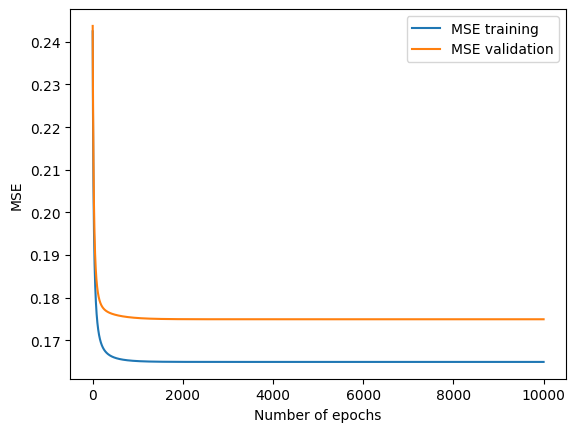

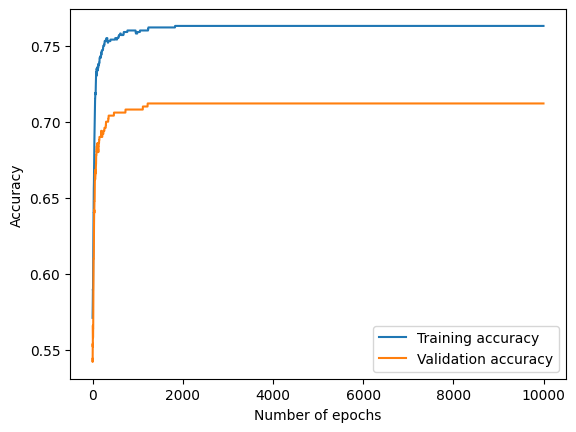

In [21]:
# plot both training loss and validation loss as functions of the number of epochs in one figure
plt.figure()
x = list(range(0,len(mse_val)))
plt.plot(list(range(len(mse))),mse, label="MSE training")
plt.plot(x,mse_val, label="MSE validation")
plt.xlabel("Number of epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()
# Both accuracies as functions of the number of epochs in another figure
plt.figure()
plt.plot(list(range(len(acc))),acc, label="Training accuracy")
plt.plot(list(range(len(acc_val))),acc_val, label="Validation accuracy")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Interesting observation, if I decrease the stepsize to 0.01, then the algorithm performs better on the test data than the
# Training data. While if I increase eta to 0.05, we achieve 78.1% accuracy for training data and 62% for the test data

## Multi-class classifiers
We turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t_multi).

### "One-vs-rest" with logistic regression
We saw in the lecture how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one logistic regression classifier for each class. To predict the class of an item, we run all the binary classifiers and collect the probability score from each of them. We assign the class which ascribes the highest probability.

Build such a classifier. Train the resulting classifier on (X_train, t_multi_train), test it on (X_val, t_multi_val), tune the hyper-parameters and report the accuracy.

Also plot the decision boundaries for your best classifier similarly to the plots for the binary case.

In [166]:
#Create a multi-class classifier
from sklearn.datasets import make_blobs
import statistics
import numpy as np
from math import e
X, t_multi = make_blobs(n_samples=[400,400,400, 400, 400], 
                        centers=[[0,1],[4,2],[8,1],[2,0],[6,0]], 
                        cluster_std=[1.0, 2.0, 1.0, 0.5, 0.5],
                        n_features=2, random_state=2022)
indices = np.arange(X.shape[0])
rng = np.random.RandomState(2022)
rng.shuffle(indices)
X_train = X[indices[:1000],:]
X_val = X[indices[1000:1500],:]
t_multi_train = t_multi[indices[:1000]]
t_multi_val = t_multi[indices[1000:1500]]

#The classifier
class MultiClassClassifier():
    def accuracy(self,y_pred,t):
        return np.sum(y_pred == t)/len(y_pred)
    
    def logistic(self,x):
        return 1/(1+e**(-x))
    
    def converta(self, t_multi_train, clas):
        return (t_multi_train == clas).astype(int)
    
    def add_bias(self,X):
        return np.c_[np.ones(len(X)).reshape(-1,1),X]
    
    def mse(self,x,y):
        return np.mean((x - y)**2)
    
    def predict_class(self,X_test,weig,add_bias=True):
        if add_bias:
            X_test = self.add_bias(X_test)
        probs = np.zeros(shape=(np.shape(weig)[0],len(X_test)))
        for clas in range(0,5):
            probs[clas] = self.logistic(X_test @ weig[clas]) 
        return np.argmax(probs,axis=0), np.max(probs,axis=0)

    def predict_class_ind(self,X_test,weig,add_bias=True,clas=0):
        if add_bias: X_test = self.add_bias(X_test)
        return (self.logistic(X_test @ weig[clas]) > 0.5).astype(int)

    def fit(self, X_train=X_train, t_multi_train=t_multi_train, X_val=X_val, t_multi_val = t_multi_val, eta = 0.1, epochs=1000, tol=0, n_epochs_no_update=100, threshold=0.05):
        #Convert the t_multi_train values based on class
        X_train = self.add_bias(X_train)
        (N, m) = X_train.shape
        self.weights = weights = np.zeros(shape=(len(np.unique(t_multi_train)),m))
        acc = list()
        mse = list()        
        acc_val = list()
        mse_val = list()
        n_epochs_no_update = epochs//10
        for clas in range(0,5):
            mse_spec = list()
            t_multi_train_ = self.converta(t_multi_train,clas)
            for epoch in range(epochs):
                y_pred = self.logistic(X_train @ weights[clas])
                weights[clas] -= eta / N *  X_train.T @ (y_pred - t_multi_train_)
                mse_spec.append(self.mse(y_pred,t_multi_train_))  
                if epoch > n_epochs_no_update:
                    if mse_spec[-1]-mse_spec[-n_epochs_no_update] < tol:
                        break
                    n_epochs_no_update += epoch
        #Calculate the accuracy and mse of the entire model
        acc.append(self.accuracy(self.predict_class(X_train,weights,add_bias=False)[0],t_multi_train))
        mse.append(self.mse(self.predict_class(X_train,weights,add_bias=False)[1],t_multi_train))
        if len(X_val) > 0:
            acc_val.append(self.accuracy(self.predict_class(X_val,weights,add_bias=True)[0],t_multi_val))
            mse_val.append(self.mse(self.predict_class(X_val,weights,add_bias=True)[1],t_multi_val))
            return weights, acc[-1], acc_val[-1], mse[-1], mse_val[-1]
        else:
            return weights, acc

MCC = MultiClassClassifier()

In [159]:
# Tuning the parameters
import time
from IPython import display

def tuning(cl, min_eta, max_eta, min_epoch, max_epoch):
    x = np.linspace(0, 10, 500)  # Update the x-data to match the shape of y-data
    y = np.linspace(0, 1, 500)
    plt.ion()

    # Creating subplots
    figure, ax = plt.subplots(figsize=(8, 5))
    line1, = ax.plot(x, y)

    # Setting title
    plt.title("Scaling", fontsize=20)

    # Setting x-axis label and y-axis label
    plt.xlabel("Number of tests")
    plt.ylabel("Percentage of accuracy")

    etas = np.random.uniform(low=min_eta, high=max_eta, size=20)
    epochs = np.linspace(start=min_epoch, stop=max_epoch,num=10, dtype=int)
    A = np.zeros(shape=(len(etas), len(epochs)))
    ys = []

    eta_bar = plt.Rectangle((0, 0), 1, 1, fc="red", edgecolor='none', alpha=0.5)  # Bar for eta
    epoch_bar = plt.Rectangle((0, 0), 1, 1, fc="blue", edgecolor='none', alpha=0.5)  # Bar for epoch
    accuracy_bar = plt.Rectangle((0, 0), 1, 1, fc="green", edgecolor='none', alpha=0.5)  # Bar for accuracy

    legend = ax.legend([eta_bar, epoch_bar, accuracy_bar], ['eta', 'epoch', 'accuracy'], loc='upper left', bbox_to_anchor=(1, 1))
    
    title_counter = 3

    for j in range(len(etas)):
        for i in range(len(epochs)):
            weights, acc, acc_val, mse, mse_val = cl.fit(X_train, t_multi_train, eta=etas[j], epochs=epochs[i])
            A[j][i] = round(mse,5)
            ys.append(acc)

            # Update the y-data with the entire array
            line1.set_xdata(range(0, len(ys)))
            line1.set_ydata(ys)  # Flatten the 2D array into a 1D array

            # Update the position and label of the eta bar
            eta_bar.set_xy((j, 0))
            eta_bar.set_label(f'eta: {etas[j]:.3f}')
            # Update the position and label of the epoch bar
            epoch_bar.set_xy((j, 1))
            epoch_bar.set_label(f'epoch: {epochs[i]}')
            # Update the position and label of the accuracy bar
            accuracy_bar.set_xy((j, 1))
            accuracy_bar.set_label(f'accuracy: {acc_val:.2f}')

            legend.set_title("Parameters")  # Set a title for the legend
            legend.get_texts()[0].set_text(eta_bar.get_label())  # Update eta bar label
            legend.get_texts()[1].set_text(epoch_bar.get_label())  # Update epoch bar label
            legend.get_texts()[2].set_text(accuracy_bar.get_label())

            # Update the x-axis limits to include the current line
            ax.set_xlim(0, len(ys)-1)

            # Update the title every 20 y-values calculated
            if len(ys) % 2 == 0:
                if title_counter % 3 == 0:
                    title_text = "Scaling"
                    title_counter += 2
                elif title_counter % 5 == 0:
                    title_text = "Scaling."
                    title_counter += 2
                elif title_counter % 7 == 0:
                    title_text = "Scaling.."
                    title_counter += 2
                elif title_counter % 9:
                    title_text = "Scaling..."
                    title_counter -= 6
                ax.set_title(title_text)

            display.display(plt.gcf())  # Display the current figure
            display.clear_output(wait=True)  # Clear the previous plot
    best_epo = epochs[np.unravel_index(np.argmin(A), A.shape)[1]]
    best_eta = etas[np.unravel_index(np.argmin(A), A.shape)[0]]
    print(f"The scaling is finished. The optimal epoch size was {best_epo} and the best eta was {best_eta:.4f}")
    return best_epo, best_eta, A

The scaling is finished. The optimal epoch size was 1000 and the best eta was 0.0015


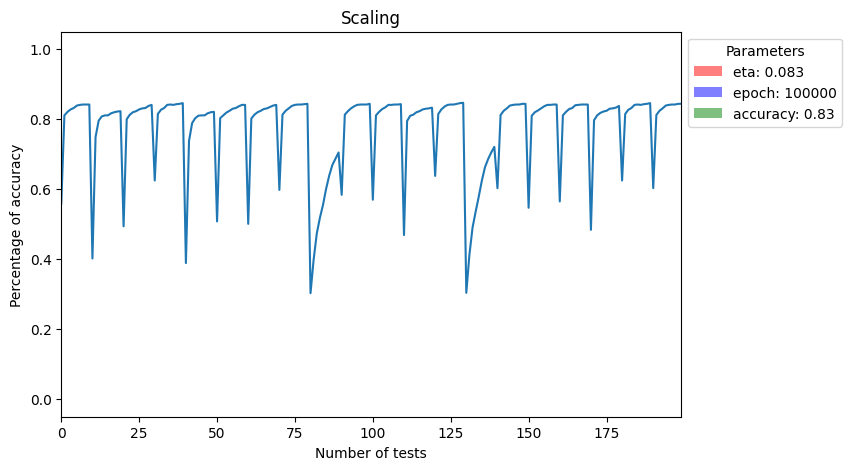

In [160]:
best_epochs, best_etas, A = tuning(MCC,min_eta=0.000001,max_eta=0.1, min_epoch=1000, max_epoch=100000)

In [161]:
MCC = MultiClassClassifier()
weights, acc, acc_val, mse, mse_val = MCC.fit(X_train,t_multi_train,epochs=best_epochs, eta=best_etas)
test_acc = MCC.accuracy(MCC.predict_class(X_test, weights),t_multi_test)
print(test_acc)

76.5


In [178]:
print(best_epochs,best_etas)

1000 0.0014908172738374785


In [134]:
def converta(t_multi_train, clas):
    return (t_multi_train == clas).astype(int)
d = np.array([1,2,3,4,2,2,2,3,4,1])
d = converta(d, 2)
d

array([0, 1, 0, 0, 1, 1, 1, 0, 0, 0])

In [181]:
def plot_decision_regions(X, t, size=(14, 4), weights=[], threshold=0.5):
    """Plot the data set (X,t) together with the decision boundary of the classifier clf"""
    # The region of the plane to consider determined by X
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Make a meshgrid of the whole region
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Create subplots for each class
    num_classes = len(np.unique(t))
    fig, axes = plt.subplots(1, num_classes, figsize=size, sharex=True, sharey=True)

    print(np.c_[xx.ravel(), yy.ravel()])

    for cur_class, ax in enumerate(axes):
        # Classify each mesh point
        Z = MCC.predict_class_ind(X_test=X, weig=weights, clas=cur_class)
        Z = Z.reshape(xx.shape)

        # Define colors for each class
        class_colors = ['blue', 'orange', 'purple', 'gray', 'red']
        cmap_colors = ['Blues', 'Oranges', 'Purples', 'gray', 'Reds']

        # Put the result into a color plot
        ax.contourf(xx, yy, Z, alpha=0.2, cmap=cmap_colors[cur_class])
        ax.scatter(X[:, 0], X[:, 1], c=[class_colors[i] for i in t], s=10.0, cmap='Paired')

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_title(f"Decision regions for {class_colors[cur_class]}")
        ax.set_xlabel("x0")
        ax.set_ylabel("x1")

    plt.tight_layout()
    plt.show()

[[-3.01449175 -3.28499118]
 [-2.99449175 -3.28499118]
 [-2.97449175 -3.28499118]
 ...
 [10.78550825  9.33500882]
 [10.80550825  9.33500882]
 [10.82550825  9.33500882]]


ValueError: cannot reshape array of size 500 into shape (632,693)

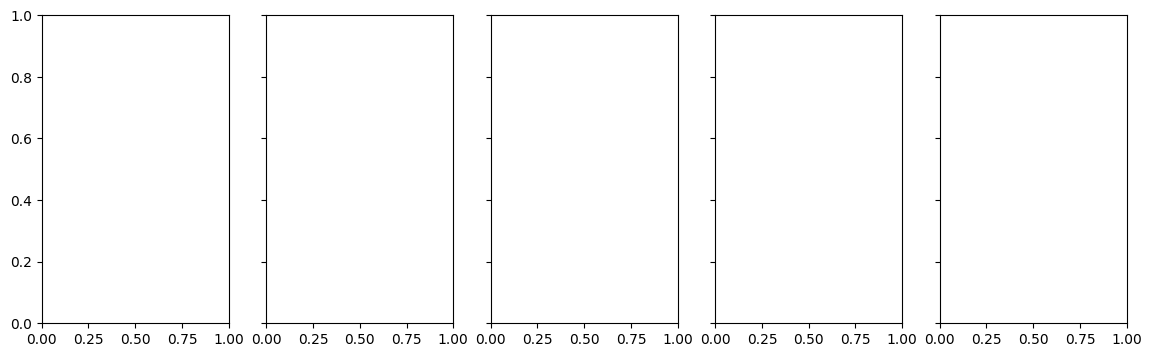

In [182]:
plot_decision_regions(X=X_test,t=t_multi_test,weights=weights)

In [176]:
def plot_decision_regions(X, t, size=(8, 6), weights=[], threshold=0.5):
    """Plot the data set (X,t) together with the decision boundaries"""
    # The region of the plane to consider determined by X
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Make a meshgrid of the whole region
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Calculate decision boundaries for each class
    num_classes = len(np.unique(t))
    Z_list = []
    for cur_class in range(num_classes):
        Z = MCC.predict_class_ind(X_test=np.c_[xx.ravel(), yy.ravel()], weig=weights,clas=cur_class,add_bias=True)
        Z = Z.reshape(xx.shape)
        Z_list.append(Z)

    # Combine the decision boundaries into one plot
    Z_combined = np.argmax(np.array(Z_list), axis=0)
    cmap = plt.cm.get_cmap('Paired', num_classes)  # Get a colormap with num_classes discrete colors
    plt.contourf(xx, yy, Z_combined, levels=np.arange(num_classes + 1) - 0.5, alpha=0.2, cmap=cmap)
    plt.scatter(X[:, 0], X[:, 1], c=t, s=10.0, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Combined decision boundaries")
    plt.xlabel("x0")
    plt.ylabel("x1")
    plt.show()

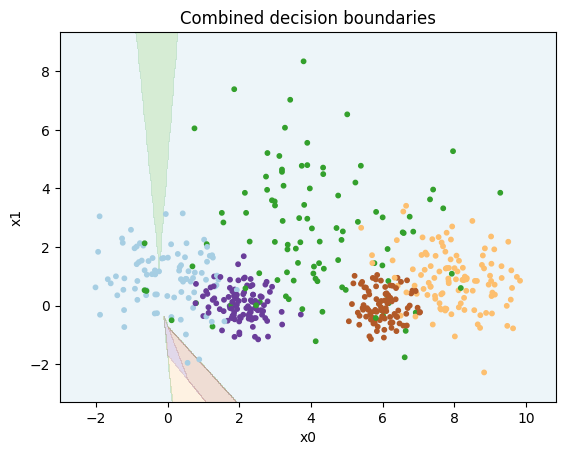

In [177]:
plot_decision_regions(X=X_test,t=t_multi_test,weights=weights)

### For in4050-students: Multi-nominal logistic regression
The following part is only mandatory for in4050-students. In3050-students are also welcome to make it a try. Everybody has to return for the part 2 on multi-layer neural networks. 

In the lecture, we contrasted the one-vs-rest approach with the multinomial logistic regression, also called softmax classifier. Implement also this classifier, tune the parameters, and compare the results to the one-vs-rest classifier. 

Remember that this classifier uses softmax in the forward phase. For loss, it uses categorical cross-entropy loss. The loss has a somewhat simpler form than in the binary case. To calculate the gradient is a little more complicated. The actual gradient and update rule is simple, however, as long as you have calculated the forward values correctly.

In [31]:
#Create a multi-class classifier
from sklearn.datasets import make_blobs
import numpy as np
from math import e
X, t_multi = make_blobs(n_samples=[400,400,400, 400, 400], 
                        centers=[[0,1],[4,2],[8,1],[2,0],[6,0]], 
                        cluster_std=[1.0, 2.0, 1.0, 0.5, 0.5],
                        n_features=2, random_state=2022)
indices = np.arange(X.shape[0])
rng = np.random.RandomState(2022)
rng.shuffle(indices)
X_train = X[indices[:1000],:]
X_val = X[indices[1000:1500],:]
X_test = X[indices[1500:],:]
t_multi_train = t_multi[indices[:1000]]
t_multi_val = t_multi[indices[1000:1500]]
t_multi_test = t_multi[indices[1500:]]
t2_train = t_multi_train >= 3
t2_train = t2_train.astype('int')
t2_val = (t_multi_val >= 3).astype('int')
t2_test = (t_multi_test >= 3).astype('int')

In [24]:
from statistics import mean

def tuning(cl, min_eta, max_eta, min_epoch, max_epoch):
    x = np.linspace(0, 10, 500)  # Update the x-data to match the shape of y-data
    y = np.linspace(0, 1, 500)

    etas = np.random.uniform(low=min_eta, high=max_eta, size=3)
    epochs = np.linspace(start=min_epoch, stop=max_epoch,num=3, dtype=int)
    A = np.zeros(shape=(len(etas), len(epochs)))

    for j in range(len(etas)):
        for i in range(len(epochs)):
            acc_train, CE_train, acc_val, CE_val, weights = cl.fit(X_train, t_multi_train, eta=etas[j], epochs=epochs[i])
            A[j][i] = CE_train[-1]

    best_epo = epochs[np.unravel_index(np.argmin(A), A.shape)[1]]
    best_eta = etas[np.unravel_index(np.argmin(A), A.shape)[0]]
    return best_epo, best_eta, A

In [33]:
#The classifier
class MultiNomialClassifier():
    def standardizer3000(self,X):
        for i in range(np.shape(X)[1]):
            X[:, i] = (X[:, i] - np.mean(X[:, i])) / (np.std(X[:, i]))
        return X

    def accuracy(self,y_pred,t):
        return np.sum(y_pred == t)/len(y_pred)
    
    def add_bias(self,X,bias=0.01):
        return np.c_[[bias]*len(X),X]
    
    def softmax(self,X):
        for rows in range(X.shape[0]):
            for cols in range(X.shape[1]):
                X[rows,cols] = np.exp(X[rows,cols]) / np.sum(np.exp(X[rows,:]), axis=0)
        return X
    
    def converta(self,t_multi_train):
        new_t_multi_train = np.zeros((len(t_multi_train),5))
        for i in range(0,len(t_multi_train)-1):
            new_t_multi_train[i][t_multi_train[i]] = 1
        return new_t_multi_train
    
    def cross_entropy(self, y_pred, t):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        cross_entropy_loss = -np.sum(t * np.log(y_pred)) / len(t)
        return cross_entropy_loss
        
    def fit(self, X_train, t_multi_train, eta = 0.001, epochs=1000, tol=0.001,X_val=X_val, t_val=t_multi_val, n_epochs_no_update=100):
        #Get the shape of the training data
        N, m = X_train.shape
        #Normalize the training data
        X_train = self.standardizer3000(X_train)
        #Add bias to the training data
        X_train = self.add_bias(X_train, bias=0.01)
        #Create an array of zeros to initialize the weights
        n_classes = len(np.unique(t_multi_train))
        self.weights = weights = np.ones((m+1, n_classes))
        #Convert the t_multi_train values based on class
        t_multi_train_bin = self.converta(t_multi_train)
        #Create two empty lists to store the accuracy and cross entropy measures
        acc = list()
        ce = list()
        acc_val = list()
        CE_val = list()
        for epoch in range(epochs):
            #Calculate the predicted values
            y_pred = np.argmax(self.softmax(np.dot(X_train, weights)),axis=1)
            #Update the weights
            weights += eta * (X_train.T @ (t_multi_train_bin - self.converta(y_pred)))
            #Calculate the accuracy and cross entropy
            acc.append(self.accuracy(y_pred,t_multi_train))
            ce.append(self.cross_entropy(y_pred, t_multi_train))
            if len(X_val) > 0:
                acc_val.append(self.accuracy(np.argmax(self.softmax(np.dot(self.add_bias(self.standardizer3000(X_val)), weights)),axis=1),t_val))
                CE_val.append(self.cross_entropy(np.argmax(self.softmax(np.dot(self.add_bias(X_val), weights)),axis=1),t_val))
            if epoch > n_epochs_no_update:
                if ce[-1]-ce[-n_epochs_no_update] < tol:
                    break
                n_epochs_no_update += epoch
        return acc, ce, acc_val, CE_val, weights
    
    def predict(self,X_test,weights1,t_multi_test):
        y_pred_b4_argmax = self.softmax(self.add_bias(self.standardizer3000(X_test)) @ weights1)
        y_pred = np.argmax(self.softmax(self.add_bias(self.standardizer3000(X_test)) @ weights1),axis=1)
        return self.accuracy(y_pred,t_multi_test), y_pred, y_pred_b4_argmax

MNC = MultiNomialClassifier()

In [36]:
#Tune the parameters
best_epochs, best_etas, A = tuning(MNC,min_eta=0.000001,max_eta=0.001,min_epoch=1000,max_epoch=10000)

In [37]:
#Run the algorithm and report the accuracy
acc, ce, acc_val, CE_val, weights = MNC.fit(X_train,t_multi_train,eta=best_etas,epochs=best_epochs)
test_acc, y_pred, argmax_ = MNC.predict(X_test,weights,t_multi_test)
print(f"The test accuracy is {test_acc}")

The test accuracy is 0.524


In [35]:
print(argmax_)

[[0.15169066 0.13870396 0.11787825 0.13092181 0.11445595]
 [0.27937972 0.28884543 0.29761726 0.25175654 0.25688595]
 [0.14639055 0.11337141 0.13198927 0.14000165 0.16569264]
 ...
 [0.31031439 0.29294749 0.34669222 0.27811312 0.33700882]
 [0.30358958 0.30118601 0.33533763 0.27335572 0.30635207]
 [0.17377305 0.13191854 0.17446606 0.16857811 0.22648734]]


# Part II Multi-layer neural networks

## A first non-linear classifier

The following code it a simple implementation of a multi-layer perceptron.
It is quite restricted.
There is only one hidden layer.
It can only handle binary classification.
In addition, it uses a simple final layer similar to the linear regression classifier above.
One way to look at it is what happens when we add a hidden layer to the linear regression classifier.

It can be used to make a non-linear classifier for the set (X, t2).
Experiment with settings for learning rate and epochs and see how good results you can get.
Report results for variouse settings.
Be prepared to train for a looooong time.
Plot the training set together with the decision regions as in part I.

In [58]:
from sklearn.datasets import make_blobs
import numpy as np
X, t_multi = make_blobs(n_samples=[400,400,400, 400, 400], 
                        centers=[[0,1],[4,2],[8,1],[2,0],[6,0]], 
                        cluster_std=[1.0, 2.0, 1.0, 0.5, 0.5],
                        n_features=2, random_state=2022)
indices = np.arange(X.shape[0])
rng = np.random.RandomState(2022)
rng.shuffle(indices)
X_train = X[indices[:1000],:]
X_val = X[indices[1000:1500],:]
X_test = X[indices[1500:],:]
t_multi_train = t_multi[indices[:1000]]
t_multi_val = t_multi[indices[1000:1500]]
t_multi_test = t_multi[indices[1500:]]
t2_train = t_multi_train >= 3
t2_train = t2_train.astype('int')
t2_val = (t_multi_val >= 3).astype('int')
t2_test = (t_multi_test >= 3).astype('int')

In [43]:
def tuning(cl,min_eta,max_eta,min_tol,max_tol,min_dim,max_dim):
    etas = np.random.uniform(low=min_eta,high=max_eta,size=10)
    tol = np.random.uniform(low=min_tol,high=max_tol,size=10)
    dims = np.linspace(start=min_dim,stop=max_dim,dtype=int)
    A = np.zeros(shape = (len(etas),len(tol),len(dims)))
    for j in range(0,len(etas)):
        for i in range(0,len(tol)-1):
            for l in range(0,len(dims)-1):
                acc, mse_ls, acc_val_ls, mse_val_ls = cl.fit(X_train,t2_train,eta=etas[j],tol=tol[i],dim_hidden=dims[l])
                A[j][i][l] = acc[-1]
    return etas[np.argwhere(A == np.amax(A))[0][0]], tol[np.argwhere(A == np.amax(A))[0][0]], dims[np.argwhere(A == np.amax(A))[0][0]], np.amax(A)  

In [55]:
from math import e
import warnings

class MLPBinaryLinRegClass():
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self, bias=-1, dim_hidden = 6):
        """Intialize the hyperparameters"""
        self.bias = bias
        self.dim_hidden = dim_hidden
        
        def logistic(x):
            warnings.filterwarnings('ignore')
            return 1/(1+e**(-x))
        self.activ = logistic
        
        def logistic_diff(y):
            return y * (1 - y)
        self.activ_diff = logistic_diff

    def forward(self, X):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        hidden_activations = self.activ(X @ self.weights1)
        hidden_outs = self.add_bias(hidden_activations)
        outputs = hidden_outs @ self.weights2
        return hidden_outs, outputs
    
    def add_bias(self,X):
        return np.c_[np.ones(len(X)).reshape(-1,1),X]

    def predict(self, X, scale=False):
        """Predict the class for the members of X"""
        #Scale the input data
        if scale == True:
            X = (X - np.mean(X, axis=0))/np.std(X, axis=0)
        #Add bias to the X data
        Z = self.add_bias(X)
        #Calculate the expected outputs
        forw = self.forward(Z)[1]
        #Choose the 0th column of outputs as output and calculate the output based on the threshold 0.5
        score = forw[:, 0]
        return score
    
    def predict_probability(self,X):
        return X / (1-X)
    
    def mse(self,y_pred,t_test):
        return np.mean(y_pred - t_test)**2
    
    def accuracy(self,y_pred,t_test):
        return np.sum((y_pred > 0.5).astype(int) == t_test)/len(y_pred)

    def fit(self, X_train, t_train, eta=0.00017, epochs = 1000, X_val=[], T_val=[], n_epochs_no_update=100, tol=0.0061, dim_hidden=6, scale=False):
        self.eta = eta
        if scale == True:
            X_train = (X_train - np.mean(X_train, axis=0))/np.std(X_train, axis=0)
        T_train = t_train.reshape(-1,1)
            
        dim_in = X_train.shape[1] 
        dim_out = T_train.shape[1]
        
        # Initialize the weights
        self.weights1 = (np.random.rand(dim_in + 1, dim_hidden) * 2 - 1)/np.sqrt(dim_in)
        self.weights2 = (np.random.rand(dim_hidden+1, dim_out) * 2 - 1)/np.sqrt(dim_hidden)

        interval_epochs = list(range(epochs//n_epochs_no_update,epochs,epochs//n_epochs_no_update))

        X_train_bias = self.add_bias(X_train)
        
        mse_ls = list()
        acc_ls = list()
        mse_val_ls = list()
        acc_val_ls = list()
        for e in range(epochs):
            # One epoch
            hidden_outs, outputs = self.forward(X_train_bias)
            #Calculate the MSE
            mse_ls.append(self.mse(outputs,T_train))
            #Calculate the accuracy
            acc_ls.append(self.accuracy((outputs > 0.5).astype(int),T_train))
            # The forward step
            out_deltas = (outputs - T_train)
            # The delta term on the output node
            hiddenout_diffs = out_deltas @ self.weights2.T
            # The delta terms at the output of the hidden layer
            hiddenact_deltas = (hiddenout_diffs[:, 1:] * self.activ_diff(hidden_outs[:, 1:]))  
            # The deltas at the input to the hidden layer
            self.weights2 -= self.eta * hidden_outs.T @ out_deltas
            self.weights1 -= self.eta * X_train_bias.T @ hiddenact_deltas 
            # Test the new weights on the validation set
            if len(X_val) > 0:
                if scale == True:
                    X_val = (X_val - np.mean(X_val, axis=0))/np.std(X_val, axis=0)
                #Calculate the outputs for the validation set
                hidden_outs, outputs_val = self.forward(self.add_bias(X_val))
                #Calculate the accuracy for the validation set
                acc_val_ls.append(self.accuracy(np.concatenate(outputs_val > 0.5).astype(int),T_val))
                #Calculate the MSE for the validation set
                mse_val_ls.append(self.mse(outputs_val,T_val))
            #Stop the learning algorithm if it does not improve with tol for n_epochs_no_update epochs
            if e > n_epochs_no_update:
                if acc_ls[-1]-acc_ls[-n_epochs_no_update] < tol:
                    break
                n_epochs_no_update += e
        return acc_ls, mse_ls, acc_val_ls, mse_val_ls

## Improving the classifier
You should now make changes to the classifier similarly to what you did with the logistic regression classifier in part 1.

a) In addition to the method predict, which predicts a class for the data, include a method predict_probability which predict the probability of the data belonging to the positive class. The training should be based on this value as with logistic regression.

b) Calculate the loss and the accuracy after each epoch and store them for inspection after training.

c) In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss and the accuracy for the validation set after each epoch.

d) The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit method with two keyword arguments, `tol` and `n_epochs_no_update` and stop training when the loss has not improved with more than tol after `n_epochs_no_update`. A possible default value for `n_epochs_no_update` is 5. Also, add an attribute to the classifier which tells us after fitting how many epochs were ran.

e) Tune the hyper-parameters:`eta`, `tol`and `dim-hidden`.
Also consider the effect of scaling the data.

f) After a succesful training with a best setting for the hyper-parameters, plot both training loss and validation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.

g) The algorithm contains an element of non-determinism. Hence, train the classifier 10 times with the optimal hyper-parameters and report the mean and standard deviation of the accuracies over the 10 runs.

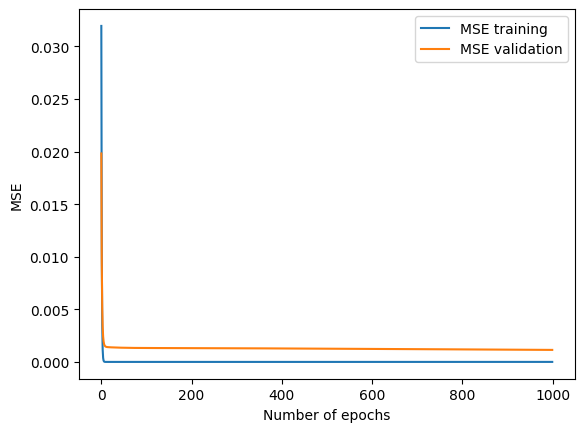

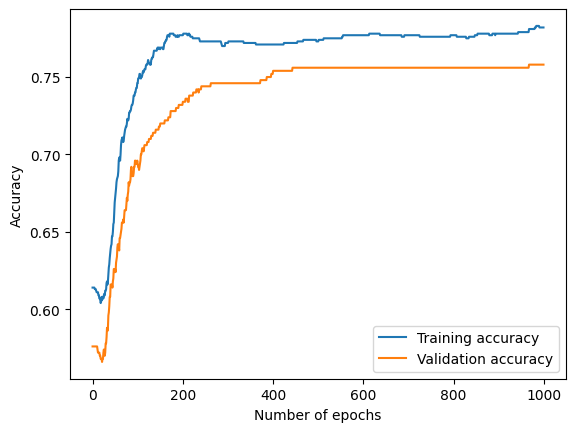

Based on the graphs we can see that the model might be overfitting, as it is performing better on the training set than on the validation set.
The average accuracy across 10 runs was 0.8 with 0.051 standard deviation


In [56]:
MLP_BinLinReg = MLPBinaryLinRegClass()
# a) Done in the class

# b) 
acc_ls, mse_ls, acc_val_ls, mse_val_ls = MLP_BinLinReg.fit(X_train,t2_train,eta=0.00017,tol=0.0061,X_val=X_val,T_val=t2_val, scale=True)
# c) The validation set has been implemented in the fit function above

# d) A limit for the number of epochs run and a tolerance for the accuracy improvement between epochs has been implemented in the fit function.

# e) Tune the hyper-paramters: eta, tol and dim-hidden. Also consider the effect of scaling the data. 
MLP_best_eta, MLP_best_tol, MLP_best_dim, best_accuracy = tuning(MLP_BinLinReg, min_eta=0.0001, max_eta=0.005, min_tol=0.01 ,max_tol=0.00001, min_dim=6, max_dim=10)

# f) 
import matplotlib.pyplot as plt
# plot both training loss and validation loss as functions of the number of epochs in one figure
plt.figure()
x = list(range(0,len(mse_val_ls)))
plt.plot(list(range(len(mse_ls))),mse_ls, label="MSE training")
plt.plot(x,mse_val_ls, label="MSE validation")
plt.xlabel("Number of epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()
# Both accuracies as functions of the number of epochs in another figure
plt.figure()
plt.plot(list(range(len(acc_ls))),acc_ls, label="Training accuracy")
plt.plot(list(range(len(acc_val_ls))),acc_val_ls, label="Validation accuracy")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
print("Based on the graphs we can see that the model might be overfitting, as it is performing better on the training set than on the validation set.")

# g) 
mean_accs = list()
std_acc = list()
MLP_BinLinReg = MLPBinaryLinRegClass()
for _ in range(10):
    acc_ls, mse_ls, acc_val_ls, mse_val_ls = MLP_BinLinReg.fit(X_train,t2_train,eta=MLP_best_eta,tol=MLP_best_tol,X_val=X_val,T_val=t2_val,dim_hidden=MLP_best_dim, scale=True)
    mean_accs.append(np.mean(acc_ls))
    std_acc.append(np.std(acc_ls))
print(f"The average accuracy across 10 runs was {round(np.mean(mean_accs),2)} with {round(np.mean(std_acc),3)} standard deviation")
    

In [54]:
print(MLP_best_tol)

0.0064057391243470055


## For IN4050-students: Multi-class neural network

The following part is only mandatory for in4050-students. In3050-students are also welcome to make it a try. (This is the most fun part of the set :) )

The goal is to use a feed-forward network for non-linear multi-class classfication and apply it to set (X, t_multi).

Modify the netork to become a multi-class classifier. As a check of your implementation, you may apply it to (X, t_2) and see whether you get similar results as above.

Train the resulting classifier on (X_train, t_multi_train), test it on (X_val, t_multi_val), tune the hyper-parameters and report the accuracy.

Plot the decision boundaries for your best classifier..

In [1]:
from sklearn.datasets import make_blobs
import time
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
X, t_multi = make_blobs(n_samples=[400,400,400, 400, 400], 
                        centers=[[0,1],[4,2],[8,1],[2,0],[6,0]], 
                        cluster_std=[1.0, 2.0, 1.0, 0.5, 0.5],
                        n_features=2, random_state=2022)
indices = np.arange(X.shape[0])
rng = np.random.RandomState(2022)
rng.shuffle(indices)
X_train = X[indices[:1000],:]
X_val = X[indices[1000:1500],:]
X_test = X[indices[1500:],:]
t_multi_train = t_multi[indices[:1000]]
t_multi_val = t_multi[indices[1000:1500]]
t_multi_test = t_multi[indices[1500:]]
t2_train = t_multi_train >= 3
t2_train = t2_train.astype('int')
t2_val = (t_multi_val >= 3).astype('int')
t2_test = (t_multi_test >= 3).astype('int')

In [2]:
import numpy as np
from IPython import display
import statistics

def tuning(cl, min_eta, max_eta, min_tol, max_tol, min_dim, max_dim, X_val, t_multi_val):

    x = np.linspace(0, 10, 500)  # Update the x-data to match the shape of y-data

    plt.ion()

    # Creating a single subplot
    fig, ax = plt.subplots(figsize=(8, 6))

    line1_CE, = ax.plot(x, np.zeros(500), label='CE', color='blue')
    line2_accuracy, = ax.plot(x, np.zeros(500), label='Accuracy', color='orange')

    # Setting titles for the subplot
    ax.set_title("CE and Accuracy Scaling", fontsize=20)

    # Setting x-axis label and y-axis label for the subplot
    ax.set_xlabel("Number of tests")
    ax.set_ylabel("CE / Accuracy")


    # Set y-axis limits to [0, 1]
    ax.set_ylim(0, 1)

    etas = np.random.uniform(low=min_eta, high=max_eta, size=5)
    tol = np.random.uniform(low=min_tol, high=max_tol, size=5)
    dims = np.linspace(start=min_dim, stop=max_dim, dtype=int)

    accuracy_values = []
    CE_values = []

    A = np.zeros(shape=(len(etas), len(tol), len(dims)))

    eta_bar = plt.Rectangle((0, 0), 1, 1, fc="red", edgecolor='none', alpha=0.5)  # Bar for eta
    tol_bar = plt.Rectangle((0, 0), 1, 1, fc="pink", edgecolor='none', alpha=0.5)  # Bar for tol
    dim_bar = plt.Rectangle((0, 0), 1, 1, fc="yellow", edgecolor='none', alpha=0.5)  # Bar for dim
    accuracy_bar = plt.Rectangle((0, 0), 1, 1, fc="orange", edgecolor='none', alpha=0.5)  # Bar for accuracy
    CE_bar = plt.Rectangle((0, 0), 1, 1, fc="blue", edgecolor='none', alpha=0.5)  # Bar for mse

    legend_accuracy = ax.legend([eta_bar, tol_bar, dim_bar, accuracy_bar, CE_bar],
                                         ['eta', 'tol', 'dim', 'accuracy', 'mse'],
                                         loc='upper left', bbox_to_anchor=(1, 1))

    legend_accuracy.set_title("Parameters")  # Set a title for the legend

    for j in range(0, len(etas)):
        for i in range(0, len(tol) - 1):
            for l in range(0, len(dims) - 1):
                acc, acc_val, CE, CE_val, e = cl.fit(X_train, t_multi_train, X_val, t_multi_val, eta=etas[j],
                                                      tol=tol[i], dim_hidden=dims[l], epochs=10000)
                A[j][i][l] = CE[-1]

                CE_values.append(statistics.mean(CE_val))
                accuracy_values.append(statistics.mean(acc_val))

                line1_CE.set_xdata(range(0, len(CE_values)))
                line1_CE.set_ydata(CE_values)

                line2_accuracy.set_xdata(range(0, len(accuracy_values)))
                line2_accuracy.set_ydata(accuracy_values)

                eta_bar.set_label(f'Eta: {etas[j]:.5f}')
                tol_bar.set_label(f'Tol: {tol[i]:.2f}')
                dim_bar.set_label(f'Dims: {dims[l]}')
                accuracy_bar.set_label(f'Accuracy: {accuracy_values[-1]:.2f}')
                CE_bar.set_label(f'CE: {CE_values[-1]:.5f}')

                legend_accuracy.get_texts()[0].set_text(eta_bar.get_label())  # Update eta bar label
                legend_accuracy.get_texts()[1].set_text(tol_bar.get_label())  # Update tol bar label
                legend_accuracy.get_texts()[2].set_text(dim_bar.get_label())  # Update dim bar label
                legend_accuracy.get_texts()[3].set_text(accuracy_bar.get_label())  # Update accuracy bar label
                legend_accuracy.get_texts()[4].set_text(CE_bar.get_label())  # Update CE bar label
                ax.set_xlim(0, len(accuracy_values) - 1)

                display.display(plt.gcf())  # Display the current figure
                display.clear_output(wait=True)

    return etas[np.argwhere(A == np.amin(A))[0][0]], tol[np.argwhere(A == np.amin(A))[0][0]], dims[
        np.argwhere(A == np.amin(A))[0][0]], np.amin(A)



In [3]:
import numpy as np

class MLP_MultiClassNN():
    """A multi-layer neural network with one hidden layer"""
    def __init__(self, dim_hidden = 6):
        """Initialize the hyperparameters"""
        self.dim_hidden = dim_hidden
        
        def logistic(x):
            return 1 / (1 + np.exp(-x))
        self.activ = logistic
        
        def logistic_diff(y):
            return y * (1 - y)
        self.activ_diff = logistic_diff

    def add_bias(self, X):
        return np.c_[np.ones(len(X)), X]
    
    def accuracy(self, y_pred, t):
        correct_predictions = np.sum(y_pred == t)
        return correct_predictions / len(t)
        
    def cross_entropy(self, y_pred, t):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        cross_entropy_loss = -np.sum(t * np.log(y_pred)) / len(t)
        return cross_entropy_loss
    
    def converta(self, t_multi_train):
        new_t_multi_train = np.zeros((len(t_multi_train), 5))
        for i in range(len(t_multi_train)):
            new_t_multi_train[i][t_multi_train[i]] = 1
        return new_t_multi_train
    
    def int_machine(self, X):
        return np.where(X < 0, 0, X.astype(int))
        
    def fit(self, X_train, t_train, X_val, t_multi_val, eta=0.001, epochs=1000, tol=1e-6, dim_hidden=6):
        self.eta = eta
        self.dim_hidden = dim_hidden
        
        T_train = self.converta(t_train)
            
        dim_in = X_train.shape[1] 
        dim_out = T_train.shape[1]
        
        # Initialize the weights
        self.weights1 = (np.random.rand(dim_in + 1, self.dim_hidden) * 2 - 1) / np.sqrt(dim_in)
        self.weights2 = (np.random.rand(self.dim_hidden + 1, dim_out) * 2 - 1) / np.sqrt(self.dim_hidden)
        X_train_bias = self.add_bias(X_train)
        
        acc = []
        loss = []
        acc_val = []
        loss_val = []
        threshold = epochs // 5

        for e in range(epochs):
            # One epoch
            hidden_outs, outputs = self.forward(X_train_bias)
            acc.append(self.accuracy(np.argmax(outputs, axis=1), t_train))
            loss.append(self.cross_entropy(outputs, T_train))
            
            # The forward step
            out_deltas = (outputs - T_train)
            hiddenout_diffs = out_deltas @ self.weights2.T
            hiddenact_deltas = (hiddenout_diffs[:, 1:] * self.activ_diff(hidden_outs[:, 1:]))
            
            self.weights2 -= self.eta * hidden_outs.T @ out_deltas
            self.weights1 -= self.eta * X_train_bias.T @ hiddenact_deltas 
            
            if len(X_val) > 0:
                outputs_val = self.forward(self.add_bias(X_val))[1]
                acc_val.append(self.accuracy(np.argmax(outputs_val, axis=1), t_multi_val))
                loss_val.append(self.cross_entropy(outputs_val, self.converta(t_multi_val)))
                
            if e > threshold and loss[-1] - loss[-threshold] < tol:
                break
                
        return acc, acc_val, loss, loss_val, e
    
    def forward(self, X):
        hidden_activations = self.activ(X @ self.weights1)
        hidden_outs = self.add_bias(hidden_activations)
        outputs = hidden_outs @ self.weights2
        softmax_outputs = np.exp(outputs) / np.sum(np.exp(outputs), axis=1, keepdims=True)
        return hidden_outs, softmax_outputs
    
    def predict(self, X_pred):
        Z = self.add_bias(X_pred)
        forw = self.forward(Z)[1]
        return np.argmax(forw, axis=1)

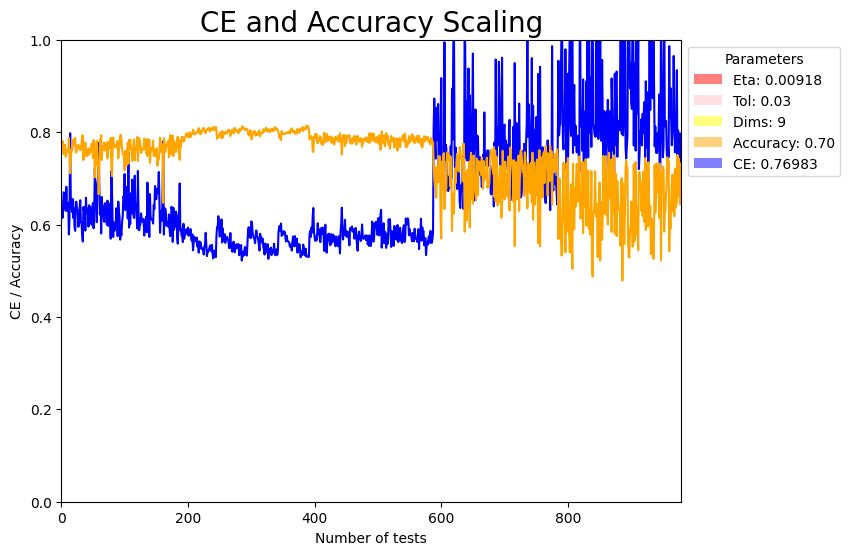

In [4]:
#Tune hyperparameters like eta, epochs, tol, and threshold
MCN = MLP_MultiClassNN()
MLP_best_eta, MLP_best_tol, MLP_best_dim, best_accuracy = tuning(cl=MCN,min_eta=0.000001,max_eta=0.01,min_tol=0.1,max_tol=0.005,min_dim=4,max_dim=10,X_val=X_val,t_multi_val=t_multi_val)

In [5]:
print(MLP_best_dim,MLP_best_eta,MLP_best_tol)

4 0.005232503219410684 0.0100131357289871


In [6]:
MCN = MLP_MultiClassNN()
acc, acc_val, CE, CE_val, e = MCN.fit(X_train, t_multi_train, 
                                      X_val, t_multi_val, epochs= 10000,
                                      eta=MLP_best_eta, tol=MLP_best_tol, 
                                      dim_hidden=MLP_best_dim) 

In [7]:
y_pred = MCN.int_machine(MCN.predict(X_test))
print(MCN.accuracy(y_pred,t_multi_test))

0.812


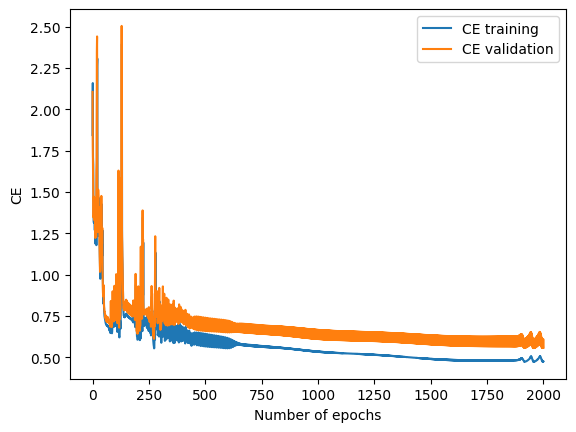

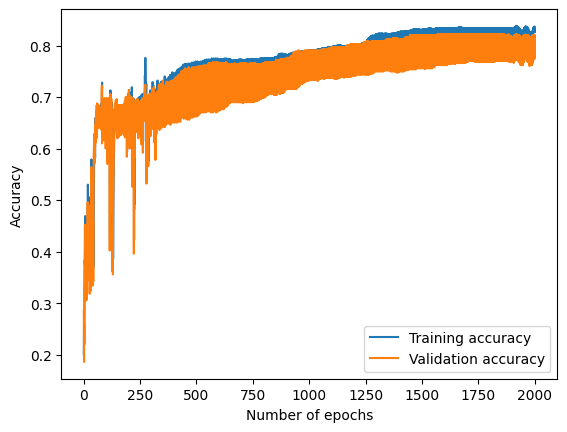

In [72]:
# plot both training loss and validation loss as functions of the number of epochs in one figure
plt.figure()
x = list(range(len(CE)))
plt.plot(x,CE, label="CE training")
plt.plot(x,CE_val, label="CE validation")
plt.xlabel("Number of epochs")
plt.ylabel("CE")
plt.legend()
plt.show()
# Both accuracies as functions of the number of epochs in another figure
plt.figure()
plt.plot(list(range(len(acc))),acc, label="Training accuracy")
plt.plot(list(range(len(acc_val))),acc_val, label="Validation accuracy")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Part III: Final testing
We can now perform a final testing on the held-out test set.

## Binary task (X, t2)
Consider the linear regression classifier, the logistic regression classifier and the multi-layer network with the best settings you found. Train each of them on the training set and calculate accuracy on the held-out test set, but also on the validation set and the training set. Report in a 3 by 3 table.

Comment on what you see. How do the three different algorithms compare? Also, compare the results between the different data sets. In cases like these, one might expect slightly inferior results on the held-out test data compared to the validation data. Is that the case here? 

Also report precision and recall for class 1.

## For IN4050-students: Multi-class task (X, t_multi)
The following part is only mandatory for in4050-students. In3050-students are also welcome to do it. It requires the earlier IN4050-only tasks. 

Compare the three multi-class classfiers, the one-vs-rest and the multinomial logistic regression from part one, and the multi-class neural network from part two. Evaluate on test, validation and training set as above. 

Comment on what you see

In [57]:
import pandas as pd
#Comparing the classifiers for the binary dataset outcomes
cl2 = NumpyLinRegClass2()
cl2_acc_train, mse, cl2_acc_val, mse_val = cl2.fit(X_train=X_train, 
                                                   t_train=t2_train, 
                                                   X_val=X_val, 
                                                   t_val=t2_val, 
                                                   eta=best_etas, 
                                                   epochs=best_epochs)
cl2_acc_test = accuracy(cl2.predict(X_test),t2_test)

LogReg = LogisticRegClassifier()
LR_acc_train, mse, mse_val, LR_acc_val, epoch = LogReg.fit(X_train,t2_train,
                                                           epochs=10000,eta=0.05,
                                                           tol=0.01,
                                                           n_epochs_no_update=1000,
                                                           X_val=X_val,t_val=t2_val) 
LR_acc_test = LogReg.accuracy(LogReg.predict(X_test),t2_test)

MLP_BinLinReg = MLPBinaryLinRegClass()
MLP_acc_train, mse_ls, MLP_acc_val, mse_val_ls = MLP_BinLinReg.fit(X_train,
                                                                   t2_train,
                                                                   eta=MLP_best_eta,
                                                                   tol=MLP_best_tol,
                                                                   X_val=X_val,
                                                                   T_val=t2_val,
                                                                   dim_hidden=MLP_best_dim, 
                                                                   scale=True)
MLP_acc_test = MLP_BinLinReg.accuracy(MLP_BinLinReg.predict(X_test,scale=True),t2_test)

#Create a dataframe with the results
df = pd.DataFrame({"Classifier":["Linear regression","Logistic regression","Multi-layer binary classifier"],
                     "Training accuracy":[cl2_acc_train[-1],LR_acc_train[-1],MLP_acc_train[-1]],
                        "Validation accuracy":[cl2_acc_val[-1],LR_acc_val[-1],MLP_acc_val[-1]],
                        "Test accuracy":[cl2_acc_test,LR_acc_test,MLP_acc_test]})
df

,Classifier,Training accuracy,Validation accuracy,Test accuracy
0,Linear regression,0.609,0.572,0.594
1,Logistic regression,0.763,0.716,0.734
2,Multi-layer binary classifier,0.888,0.880,0.872


In [84]:
MCC = MultiClassClassifier()
ws, acc_MCC, acc_val_MCC = MCC.fit(X_train=X_train, t_multi_train=t_multi_train, X_val=X_val, t_multi_val = t_multi_val, eta = best_etas, epochs=best_epochs, tol=0.01, n_epochs_no_update=100, clas=0, threshold=0.05)
weights = MCC.train_dat(X_train_=X_train, t_multi_train_=t_multi_train, eta=best_etas, epoch=best_epochs)
acc_test_MCC = MCC.accuracy(MCC.predict_class(X_val=X_val, ws_=weights, cls=0, threshold=0.5), t_multi_test)


In [ ]:
MCNN = MultiClassNN()


In [88]:
print(acc_MCC[-1], acc_val_MCC[-1], acc_test_MCC)

0.941 0.798 0.188


In [ ]:
#These results demonstrate that the multi-layer binary classifier performs the best on the test set. 
# It is also interesting to note that the test set overall has higher accuracy than the validation set.
# This is probably due to the fact that the validation set is a subset of the training set.

In [82]:
MCC = MultiClassClassifier()
weights, acc, acc_val = MCC.fit(X_train=X_train, t_multi_train=t_multi_train, X_val=X_val, t_multi_val = t_multi_val, eta = 0.1, epochs=1000, tol=0.01, n_epochs_no_update=100, clas=0, threshold=0.05)
test_acc = MCC.accuracy(MCC.predict_class(X_val=X_test, ws_=weights, cls=0, threshold=0.5), t_multi_test)

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [ ]:
#Comparing the accuracy across the three classifier models

import pandas as pd
#Comparing the classifiers for the multiple dataset outcomes


MCN = MLP_MultiClassNN()
MCN_acc, MCN_acc_val, MCN_CE, MCN_CE_val, e = MCN.fit(X_train, t_multi_train, 
                                      X_val, t_multi_val, epochs= 10000,
                                      eta=MLP_best_eta, tol=MLP_best_tol, 
                                      dim_hidden=MLP_best_dim) 
MCN_test_acc = MCN.accuracy(MCN.int_machine(MCN.predict(X_test)),t_multi_test)


#Create a dataframe with the results
df = pd.DataFrame({"Classifier":["Linear regression","Logistic regression","Multi-layer binary classifier"],
                     "Training accuracy":[cl2_acc_train[-1],LR_acc_train[-1],MLP_acc_train[-1]],
                        "Validation accuracy":[cl2_acc_val[-1],LR_acc_val[-1],MLP_acc_val[-1]],
                        "Test accuracy":[cl2_acc_test,LR_acc_test,MLP_acc_test]})
